In [1]:
import os
import sys
import time
import copy

import numpy as np
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms, models

from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

seed = 12345
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rc('figure', figsize=(12, 12))

use_cuda = torch.cuda.is_available()
use_cuda

True

## Load and view images

In [2]:
mean_vec = Variable(torch.FloatTensor([ 0.485, 0.456, 0.406 ]).view(1,3,1,1)).cuda()
std_vec = Variable(torch.FloatTensor([ 0.229, 0.224, 0.225 ]).view(1,3,1,1)).cuda()

def normalise_batch(batch):
    # batch of variables
    batch.div_(255.0)
    batch.sub_(mean_vec)
    batch /= std_vec
    return batch

def gram_matrix(batch):
    b, ch, h, w = batch.size()
    features = batch.view(b, ch, w * h)
    features_T = features.transpose(1,2)
    gram = features.bmm(features_T) / (ch * h * w)
    return gram

In [3]:
class SimpleImageDataset(Dataset):
    
    def __init__(self, img_dir, transform):
        super(SimpleImageDataset, self).__init__()
        
        self.image_fnames = [os.path.join(img_dir, f) for f in os.listdir(img_dir)
                             if os.path.isfile(os.path.join(img_dir, f))]
        self.transform = transform
    
    def __getitem__(self, index):
        img = Image.open(self.image_fnames[index]).convert('RGB')
        return self.transform(img)
    
    def __len__(self):
        return len(self.image_fnames)

In [4]:
image_size = 128
batch_size = 32
train_dir_name = '/home/samir/Downloads/ILSVRC2012_img_train/train'
test_dir_name = '/home/samir/Downloads/ILSVRC2012_img_train/valid'

transform = transforms.Compose([
    transforms.Scale(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

test_transform = transforms.Compose([
    transforms.Scale(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

train_dataset = SimpleImageDataset(train_dir_name, transform)
test_dataset = SimpleImageDataset(test_dir_name, test_transform)

train_data_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=7,
    pin_memory=True)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True)

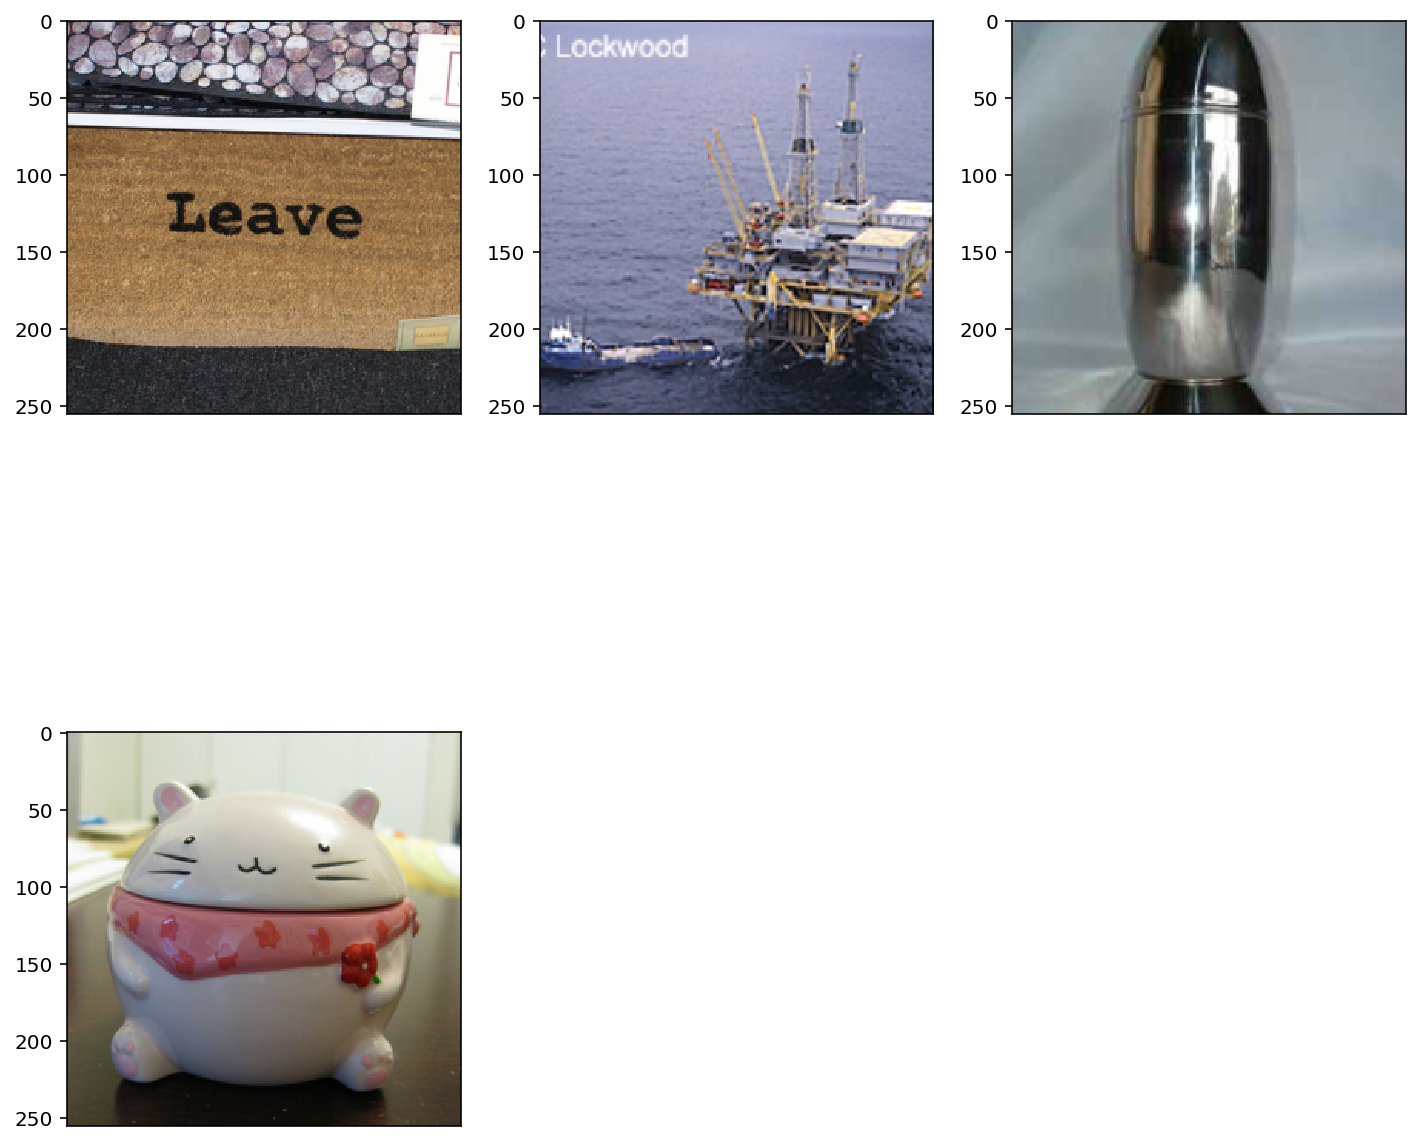

In [5]:
# preview
imgs = next(iter(train_data_loader))

plt.figure()
n = 4
for i in range(n):
    ax = plt.subplot((n//3)+1,3,i+1)
    img = transforms.ToPILImage()(imgs[i] / 255.0)
    ax.axes.get_xaxis().set_visible(False)
    plt.imshow(img)
plt.show()

## Define neural networks

In [6]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        
        self.reflect_pad = nn.ReflectionPad2d(kernel_size // 2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
    
    def forward(self, x):
        return self.conv(self.reflect_pad(x))

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.inorm1 = nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.inorm2 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU() # leaky relu? elu?
        
    def forward(self, x):
        residual = x
        out = self.relu(self.inorm1(self.conv1(x)))
        out = self.inorm2(self.conv2(x))
        return out + residual

class UpsampleConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        
        self.upsample = upsample
        if upsample:
            self.upsample_layer = nn.Upsample(scale_factor=upsample)
        self.reflect_pad = nn.ReflectionPad2d(kernel_size // 2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
    
    def forward(self, x):
        if self.upsample:
            x = self.upsample_layer(x)
        return self.conv(self.reflect_pad(x))
    
class ArtistNet(nn.Module):
    
    def __init__(self):
        super(ArtistNet, self).__init__()
        
        self.conv1 = ConvLayer(3, 32, 9, 1)
        self.inorm1 = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, 3, 2)
        self.inorm2 = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, 3, 2)
        self.inorm3 = nn.InstanceNorm2d(128, affine=True)
        
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        
        self.deconv1 = UpsampleConvLayer(128, 64, 3, 1, upsample=2)
        self.inorm4 = nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, 3, 1, upsample=2)
        self.inorm5 = nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, 9, 1)
        
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.inorm1(self.conv1(x)))
        x = self.relu(self.inorm2(self.conv2(x)))
        x = self.relu(self.inorm3(self.conv3(x)))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = self.res5(x)
        x = self.relu(self.inorm4(self.deconv1(x)))
        x = self.relu(self.inorm5(self.deconv2(x)))
        return self.deconv3(x)

In [8]:
# artist = ArtistNet().cuda()
optimiser = Adam(artist.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

In [9]:
class VGGActivationNet(nn.Module):
    
    def __init__(self):
        super(VGGActivationNet, self).__init__()
        
        vgg_features = models.vgg16(pretrained=True).features
        children = list(vgg_features.children())
        
        self.slice1 = nn.Sequential(*children[:4])
        self.slice2 = nn.Sequential(*children[4:9])
        self.slice3 = nn.Sequential(*children[9:16])
        self.slice4 = nn.Sequential(*children[16:23])
        
        for param in self.parameters():
            param.requires_grad = False
        
        names = ['relu_1_2', 'relu_2_2', 'relu_3_3', 'relu_4_3']
        self.name_activations = namedtuple('VGGActivations', names)
    
    def forward(self, x):
        relu_1_2 = self.slice1(x)
        relu_2_2 = self.slice2(relu_1_2)
        relu_3_3 = self.slice3(relu_2_2)
        relu_4_3 = self.slice4(relu_3_3)
        out = self.name_activations(relu_1_2, relu_2_2, relu_3_3, relu_4_3)
        return out

In [10]:
vgg = VGGActivationNet().cuda()

In [31]:
style_img_path = '/home/samir/Documents/super-resolution-neural-style/data/picasso.jpg'

style_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

# preprocess style image
style_img = Image.open(style_img_path)
style_img = style_img.resize((image_size, image_size), Image.ANTIALIAS)
style_img = style_transform(style_img)[:3,:,:]
style_batch = style_img.repeat(batch_size, 1, 1, 1)

# preview
style_preview = transforms.ToPILImage()(style_batch[0] / 255)

# compute style activations
style_batch = Variable(style_batch).cuda()
style_batch = normalise_batch(style_batch)
style_activations = vgg(style_batch)
style_gram = [gram_matrix(x) for x in style_activations]

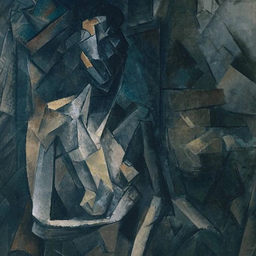

In [32]:
style_preview

## Training

In [15]:
content_weight = 1e5
style_weight = 1e10
epochs = 1

print('Training ...')
for epoch in range(epochs):
    
    artist.train()
    
    agg_content_loss = 0.
    agg_style_loss = 0.
    
    count = 0
    for batch_id, x in enumerate(train_data_loader):
        
        n_batch = len(x)
        count += n_batch
        
        optimiser.zero_grad()
        x = Variable(x).cuda() # input images batch
        y = artist(x) # generated images batch
        
        # get vgg activations (features)
        # the activations are used for both content and style loss
        y = normalise_batch(y)
        x = normalise_batch(x)
        y_activ = vgg(y)
        x_activ = vgg(x)
        
        # calculate content loss
        content_loss = content_weight * mse_loss(y_activ.relu_2_2, x_activ.relu_2_2)
        
        # calculate style loss
        # between the gram matrices of generated image and style image
        style_loss = 0.
        for y_a, gm_s in zip(y_activ, style_gram):
            gm_y = gram_matrix(y_a)
            style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
        style_loss *= style_weight
        
        total_loss = content_loss + style_loss
        total_loss.backward()
        optimiser.step()
        
        agg_content_loss += content_loss.data[0]
        agg_style_loss += style_loss.data[0]
        
        # log training
        if (batch_id + 1) % 100 == 0:
            
            avg_content_loss = agg_content_loss / (batch_id + 1)
            avg_style_loss = agg_style_loss / (batch_id + 1)
            avg_total_loss = (agg_content_loss + agg_style_loss) / (batch_id + 1)
            
            msg = '{}\tEpoch {}:\t[{}/{}]\ncontent: {:.6f}\tstyle: {:.6f}\ttotal: {:.6f}'
            msg = msg.format(
                time.ctime(),
                epoch+1,
                count,
                len(train_dataset),
                avg_content_loss,
                avg_style_loss,
                avg_total_loss)
            
            print(msg)

Training ...
Thu Nov  9 14:17:17 2017	Epoch 1:	[1600/80000]
content: 408079.137813	style: 70222.774297	total: 478301.912109
Thu Nov  9 14:18:01 2017	Epoch 1:	[3200/80000]
content: 405661.613906	style: 68674.148242	total: 474335.762148
Thu Nov  9 14:18:46 2017	Epoch 1:	[4800/80000]
content: 401737.062917	style: 67888.405560	total: 469625.468477
Thu Nov  9 14:19:31 2017	Epoch 1:	[6400/80000]
content: 399970.888281	style: 67616.350986	total: 467587.239268
Thu Nov  9 14:20:16 2017	Epoch 1:	[8000/80000]
content: 399225.597375	style: 67446.774758	total: 466672.372133
Thu Nov  9 14:21:00 2017	Epoch 1:	[9600/80000]
content: 398572.024896	style: 67314.713900	total: 465886.738796
Thu Nov  9 14:21:45 2017	Epoch 1:	[11200/80000]
content: 397725.333482	style: 67171.537963	total: 464896.871445
Thu Nov  9 14:22:30 2017	Epoch 1:	[12800/80000]
content: 398208.134570	style: 67268.831294	total: 465476.965864
Thu Nov  9 14:23:15 2017	Epoch 1:	[14400/80000]
content: 397772.728125	style: 67191.017773	total:

Process Process-14:
KeyboardInterrupt
Process Process-12:
Process Process-11:
Process Process-8:
Process Process-9:
Process Process-10:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/samir/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/samir/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/samir/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/samir/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/samir/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 35, in _worker_loop
    r = index_queue.get()
  File "/home/samir/anaconda3/lib/python3.6/site-packages/torch/utils/data/dataloader.py

KeyboardInterrupt: 

## Test model

In [24]:
artist = torch.load('./artist-model-128').cuda()
artist.eval();

In [25]:
# preview
it_test_data_loader = iter(test_data_loader)
imgs = next(it_test_data_loader)
imgs = Variable(imgs, volatile=True).cuda()

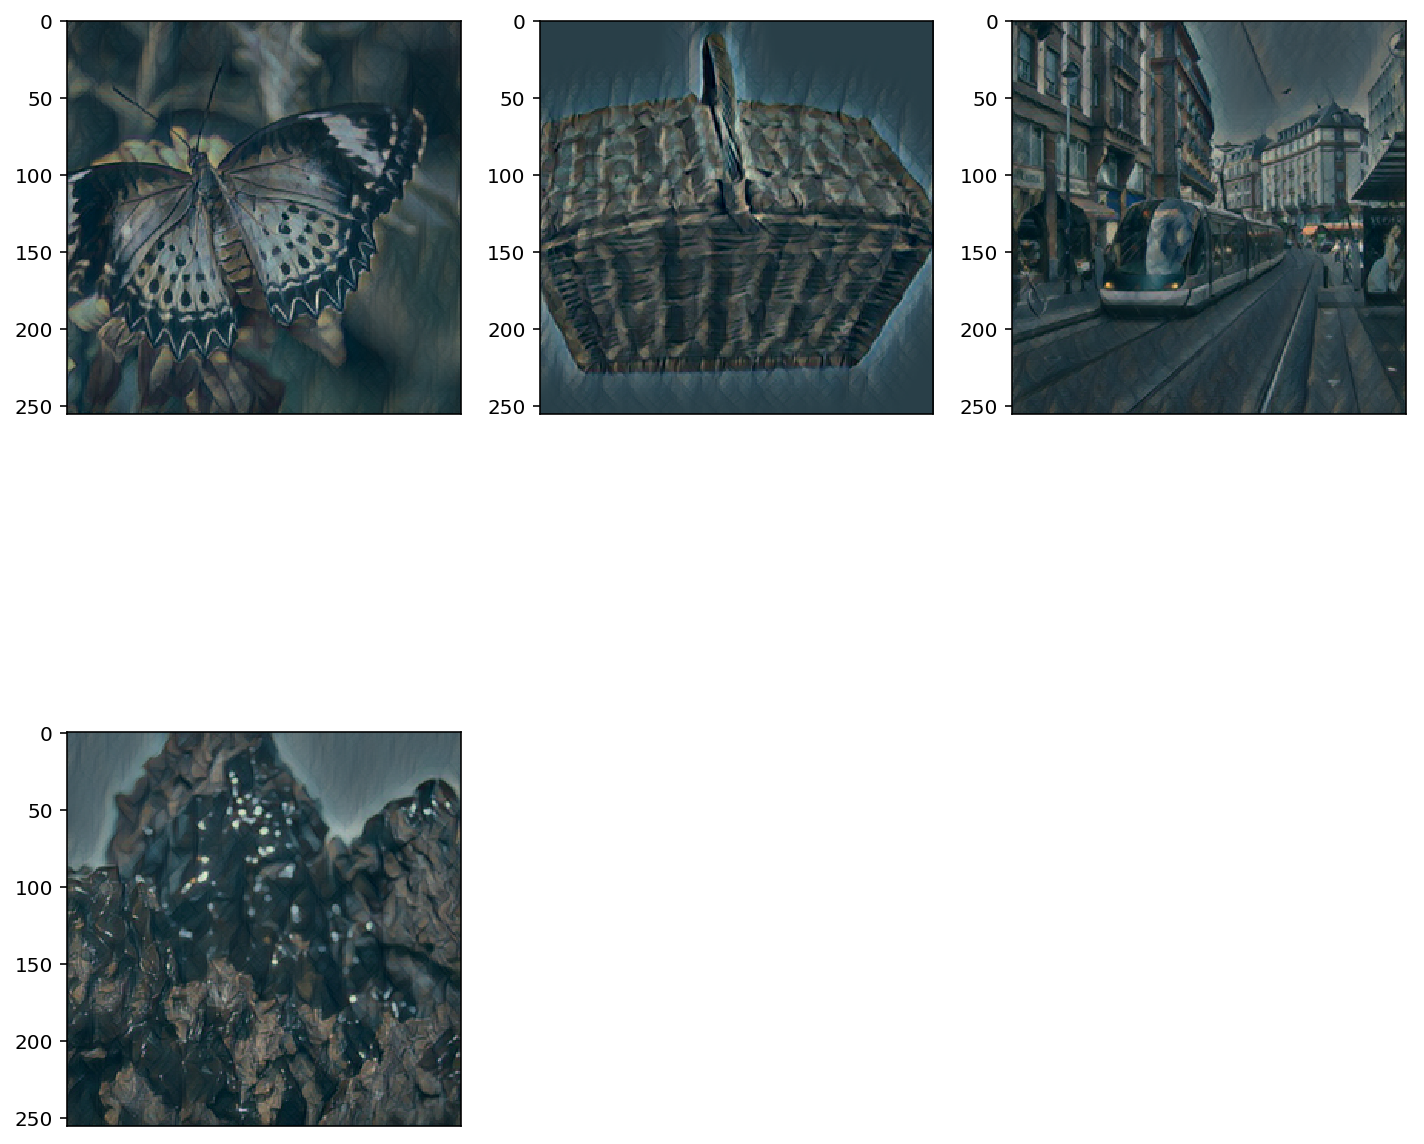

In [26]:
out = artist(imgs)
out = out.cpu().data

plt.figure()
n = 4
for i in range(n):
    ax = plt.subplot((n//3)+1,3,i+1)
    img = transforms.ToPILImage()(out[i].clamp(0,255) / 255.0)
    ax.axes.get_xaxis().set_visible(False)
    plt.imshow(img)
plt.show()

In [27]:
single_test_img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

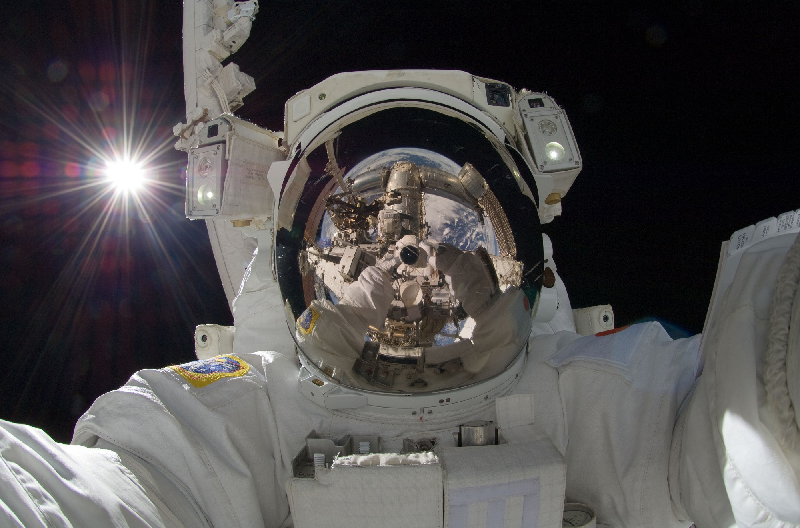

In [51]:
img = Image.open('/home/samir/Documents/super-resolution-neural-style/data/space-selfie.jpg')
original_size = img.size
original_size = ((original_size[0] // 10) * 4, (original_size[1] // 10) * 4)
img = img.resize(original_size)
img

In [52]:
img.size

(800, 528)

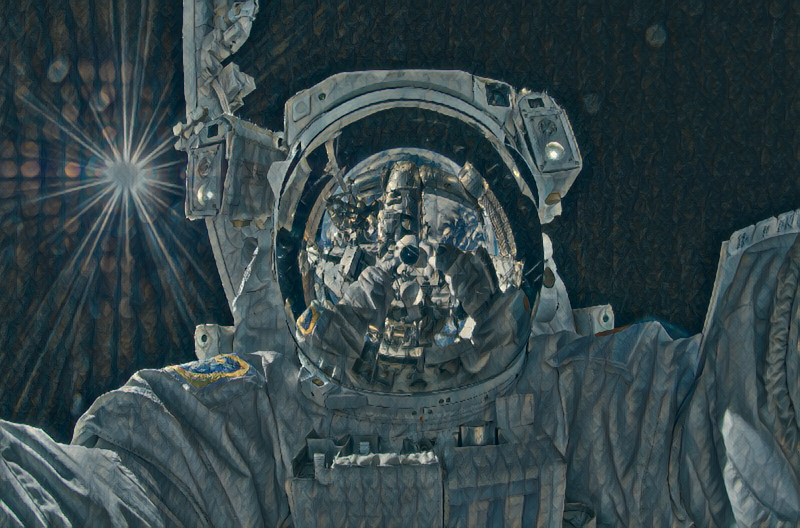

In [53]:
out = Variable(single_test_img_transform(img)[:3], volatile=True).unsqueeze(0).cuda()
out = artist(out)
out = out.cpu().data
transforms.ToPILImage()(out[0].clamp(0,255) / 255.0)

## Save model

In [23]:
artist.eval()
artist = artist.cpu()

name = 'deepart-model-e2-b16-i256'
torch.save(artist, './' + name)
torch.save(artist.state_dict(), './' + name + '.state')

/home/samir/anaconda3/lib/python3.6/site-packages/torch/serialization.py:155: UserWarning: Couldn't retrieve source code for container of type ArtistNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/samir/anaconda3/lib/python3.6/site-packages/torch/serialization.py:155: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/samir/anaconda3/lib/python3.6/site-packages/torch/serialization.py:155: UserWarning: Couldn't retrieve source code for container of type ResidualBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/samir/anaconda3/lib/python3.6/site-packages/torch/serialization.py:155: UserWarning: Couldn't retrieve source code for container of type UpsampleConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.